# Collecting and analyzing data about Stanford tuition


> *A little more than one year ago Stanford students paid no tuition fee. Just one year ago a charge of 40 dollars per quarter was made to all students for the first time in the history of the institution. In less than one year from now every student entering the University for the first time will pay a tuition fee of 225 dollars a year.*

> *What does this all mean? Every Stanford Alumnus will and should be asking himself this question: Is Stanford no longer to be the institution of the "good old days"? Does it mean that the poor man is no longer to be welcome to the campus; that Stanford is to be a "rich man's college"; that the Stanford "S" will henceforth be spelled with the "＄" sign?*

> *&mdash; ["The Second Tuition Bomb" - The Stanford Illustrated Review (books.google.com)](https://books.google.com/books?id=dMDmAAAAMAAJ&lpg=PT5&ots=JM5OTxRHRl&dq=stanford%20first%20tuition%20increase&pg=PT5#v=onepage&q&f=false)* 

The above lament comes from the editorial page of the Stanford Illustrated Review in its __January 1921 edition__. Ninety-five years later, tuition is still (mostly) mandatory. While we can't ascertain if Stanford (or "＄tanford") has continued to stray from the "good old days" from before 1920, we can at least analyze the raw tuition fee numbers as Stanford lists them on its [Administration & Finances Facts page](http://facts.stanford.edu/administration/finances). Let's scrape the data from the HTML data and programmatically chart the data to better see the trend. 

This web-scraping-to-Matplotlib-tutorial comes from the [COMM 277A: Computational Journalism 2015 lesson plan](http://www.compjour.org/weeks/6/). It should work with an [Anaconda installation of Python 3.x](https://www.continuum.io/downloads)





## Download the data

Scroll down the [Stanford Finances page](http://facts.stanford.edu/administration/finances) to find this HTML table:

![image stanford-tuition-html-table.png](images/stanford-tuition-html-table.png)

Note that not every year is listed. For consecutive years in which the tuition remained the same, the year column contains the starting year of the tuition change. For example, in the 1950s, tuition was pegged at 660 dollars, until 1960, when it was raised to 1,005 dollars:

| Academic year | Tuition |
|---------------|---------|
| 1940-41       | 345    |
| 1950-51       | 660    |
| 1960-61       | 1,005  |


This is what the HTML looks like:

```html
<table class="table table-striped data-table col-1-text">
    <thead>
        <tr>
            <th>Academic Year</th>
            <th>Tuition</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td width="49%">1920-21</td>
            <td width="51%">$120</td>
        </tr>
        <tr>
            <td>1930-31</td>
            <td>$300</td>
        </tr>
        <tr>
            <td>1940-41</td>
            <td>$345</td>
        </tr>
        <tr>
            <td>1950-51</td>
            <td>$660</td>
        </tr>
    </tbody>
</table>
```


Below is the Python to scrape it, with the use of the [lxml library for HTML parsing](http://lxml.de/):


In [12]:
# scraping stanford's tuition page

import pandas as pd
import csv
from lxml import html
import requests
import re
# live site is at: "http://facts.stanford.edu/administration/finances"
# mirror can be found here:
# http://stash.compjour.org/mirrors/facts.stanford.edu/administration/finances.html
url = 'http://facts.stanford.edu/administration/finances'
resp = requests.get(url)
doc = html.fromstring(resp.text)
table = doc.cssselect('table')[3]

rows = []
for trs in table.cssselect('tr')[1:]:
    yr, cost = [t.text for t in trs]
    # cut off the "1959" part of "1950-1959"
    rows.append( [int(yr.split('-')[0]), int(re.sub('\D', '', cost))])

# alternatively
# rows = [( int(tds[0].text.split('-')[0]), int(re.sub('\D', '', tds[1].text))) for tds in
#              [trs for trs in table.cssselect('tr')[1:]]]

Now we need to fill in the gaps between the decades; for years in which no tuition is specified, we assume it's the same tuition as the previous year.

Warning: convoluted code to follow

In [13]:
# make a row for every year
tuition_rows = []
for row in rows:
    if len(tuition_rows) > 0:
        lastyr, lastcost = tuition_rows[-1]
        tuition_rows.extend([[lastyr + i, lastcost] for i in range(1, row[0] - lastyr)])
    tuition_rows.append(row)

# Now make a dataframe
tuition_df = pd.DataFrame(tuition_rows, columns = ['year', 'tuition'])

Let's check the first and last few rows with the `head()` and `tail()` methods of the dataframe:

In [14]:
tuition_df.head()

,year,tuition
0,1920,120
1,1921,120
2,1922,120
3,1923,120
4,1924,120


In [15]:
tuition_df.tail()

,year,tuition
91,2011,40050
92,2012,41250
93,2013,42690
94,2014,44184
95,2015,45729


Looks good!

### Make an inflation-calcuation function

Of course, the value of a dollar has changed just as much as the actual tuition fee.

Before 1990, Stanford raised tuition on a per-decade basis to (awkwardly) keep up with inflation. Afterwards, tuition increases were made on an annual basis. At first, [they had hoped to keep tuition increases to 1 percent above inflation, but weren't able to maintain that policy](http://news.stanford.edu/pr/92/920212Arc2419.html):

> The combined rate for tuition and room and board for a Stanford University undergraduate will increase 7.5 percent to 22,850 next fall, the Board of Trustees decided Tuesday, Feb. 11. Tuition will go up 9.5 percent, from 15,102 to 16,536, while room and board will increase 2.5 percent, from 6,160 to 6,314. The increase represents a departure from a two-year-old policy of holding Stanford's tuition to 1 percent above inflation and keeping room and board increases as low as possible.
>
> Provost James N. Rosse said he regretted not being able to continue the strategy.
>
> "Having taken the leadership position, we found there are no followers," Rosse said.
>
> - [Undergraduate tuition, room and board to increase 7.5 percent, Feb. 12, 1992 (news.stanford.edu)](http://news.stanford.edu/pr/92/920212Arc2419.html) 




Let's gather CPI/inflation data from OKFN (the latest year in the set is 2014):

[US Consumer Price Index and Inflation (CPI)](http://data.okfn.org/data/core/cpi-us)


In [16]:
########################
# Set up inflation calculator

url = 'https://raw.githubusercontent.com/datasets/cpi-us/master/data/cpiai.csv'
cpidata = list(csv.reader(requests.get(url).text.splitlines()))
cpidf = pd.DataFrame(cpidata[1:], columns = cpidata[0])
cpidf = pd.DataFrame.convert_objects(cpidf, convert_dates = 'coerce', convert_numeric = True)
cpimean_df = cpidf.groupby(cpidf['Date'].map(lambda x: x.year)).mean()

def adjust_for_inflation(amt, from_year, to_year=2014, max_year=2014):
    f_year = min(from_year, max_year) # don't have 2015 data
    ratio = cpimean_df['Index'][to_year] / cpimean_df['Index'][f_year]
    return int(round(ratio * amt))

tuition_df['adjusted_tuition'] = tuition_df.apply(lambda row: adjust_for_inflation(row['tuition'], row['year']), axis=1)
tuition_df.head(15)



/Users/dtown/.pyenv/versions/anaconda3-2.4.0/lib/python3.5/site-packages/ipykernel/__main__.py:7: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.


,year,tuition,adjusted_tuition
0,1920,120,1401
1,1921,120,1573
2,1922,120,1676
3,1923,120,1646
4,1924,120,1639
5,1925,120,1600
6,1926,120,1586
7,1927,120,1617
8,1928,120,1636
9,1929,120,1636


## Charting time


Now we can chart.


In [17]:
import matplotlib.pyplot as pyplot
# this part is needed if you are doing this in an iPython notebook
%matplotlib inline

### Tuition, sans inflation

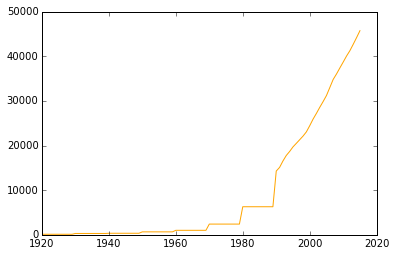

In [18]:
pyplot.plot(tuition_df['year'], tuition_df['tuition'], color='orange')

### Tuition, adjusted for inflation

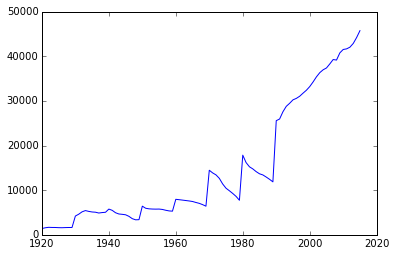

In [19]:
pyplot.plot(tuition_df['year'], tuition_df['adjusted_tuition'], color='blue')

### Tuition, non-adjusted and adjusted for inflation; on the same chart

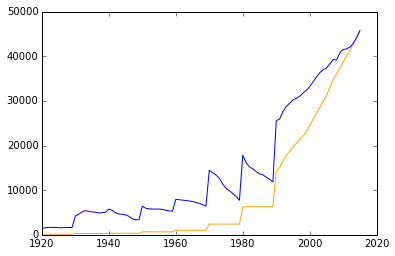

In [20]:
pyplot.plot(tuition_df['year'], tuition_df['tuition'], label = 'Unadjusted', color = 'orange')
pyplot.plot(tuition_df['year'], tuition_df['adjusted_tuition'], label = 'Adjusted', color = 'blue')

## Tuition since 1990; adjusted and non-adjusted

Sometimes it's more helpful to see just the most recent couple of decades; again, unadjusted is in the orange, adjusted-for-inflation is in the blue:

(0, 50000.0)

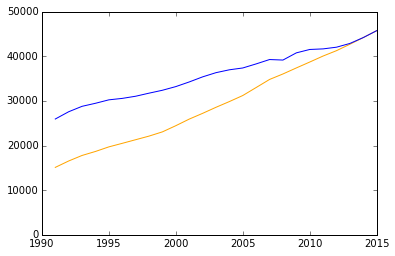

In [21]:
xdf = tuition_df[tuition_df['year'] > 1990]

pyplot.plot(xdf['year'], xdf['tuition'], label = 'Unadjusted', color = 'orange')
pyplot.plot(xdf['year'], xdf['adjusted_tuition'], label = 'Adjusted', color = 'blue')
pyplot.ylim(ymin = 0)

# The good ol days for ＄tanford?

There's a lot more to assessing the increase of tuition than tuition fees themselves. For example, student fees ([listed here](https://registrar.stanford.edu/students/tuition-and-fees)) and living costs are non-trivial factors. On the other hand, the Stanford Review editorial board's worry that [Stanford would become just a "rich man's college"](https://books.google.com/books?id=dMDmAAAAMAAJ&lpg=PT5&ots=JM5OTxRHRl&dq=stanford%20first%20tuition%20increase&pg=PT5#v=onepage&q&f=false) hasn't entirely come to pass -- Stanford has long since given free tuition to students from families from lower household incomes ([up to ＄125,000 -- which benefits nearly 30 percent of undergraduates](http://www.theatlantic.com/education/archive/2015/04/stanfords-tuition-giveaway-is-not-good-news/390090/)). Also worth considering: whether the _value_ of a Stanford education has increased accordingly, even since the days when [Herbert Hoover made his journey from dorm rat to builder of towers](https://books.google.com/books?id=hwnHCgAAQBAJ&pg=PT21&lpg=PT21&dq=herbert+hoover+stanford+dorm&source=bl&ots=XH2_2LPNHi&sig=oawDx4TlhDrlEGRZrG6oQbwCU54&hl=en&sa=X&ved=0ahUKEwilipng9cfLAhUO8GMKHYTLBd0Q6AEIWDAN#v=onepage&q=herbert%20hoover%20stanford%20dorm&f=false).

Those are all factors that can't be accounted for in tuition data alone; further study would require gathering tuition data from all of Stanford's peers. But it's a nice start to have Stanford's numbers in easily scrapable form. 

### Exploring other schools' tuition

The Chronicle of Higher Education put out a neat tool a few years ago: [Interactive Tool: Tuition Over Time, 1999-2010 - Admissions](http://chronicle.com/article/Interactive-Tool-Tuition-Over/125043/) 

<a href="http://chronicle.com/article/Interactive-Tool-Tuition-Over/125043/"><img src="images/chronicle-interactive-tuition-viz.png" alt="Chronicle viz snapshot"></a>



Here's some more fun historical reads about tuition over the decades (note, as in previous excerpts, I've cut out the dollar signs [because apparently that causes conflicts in iPython notebook's Markdown parsing](https://github.com/ipython/ipython/issues/3197/)):


- Sterling Gives Reasons Behind Tuition Increase; Points Up Stanford's 800,000 Deficit This Year, Rising Educational Costs - [The Stanford Daily 25 May 1950 (stanforddailyarchive.com)](http://stanforddailyarchive.com/cgi-bin/stanford?a=d&d=stanford19500525-01.2.22&e=-------en-20--1--txt-txIN-------) 


- [THE 10,000-A-YEAR COLLEGE EDUCATION HAS ARRIVED - New York Times (1981)](http://www.nytimes.com/1981/02/19/nyregion/the-10000-a-year-college-education-has-arrived.html) - The price of a college education, which hard-pressed parents have long said is going through the roof, has done just that - only there is apparently no longer a roof. As Gertrude Stein said, "When you get there, there is no there there." For 1981-82 undergraduates, tuition charges alone are crashing through the 7,000 barrier for the first time. Total fees, including room and board, are not only shooting past 10,000, but also emerging strong on the other side at such pace-setting schools as Harvard, Yale, Brown, Bennington, Columbia, the Massachusetts Institute of Technology and Stanford.


- [RISES IN COLLEGE TUITION AND FEES ARE MODERATING, March 13, 1984 - (nytimes.com)](http://www.nytimes.com/1984/03/13/nyregion/rises-in-college-tuition-and-fees-are-moderating.html) - The local pattern is reflected elsewhere. Officials at Harvard University said they expect to raise tuition, room and board, which is now 13,150, by "6 to 8 percent," while __Stanford University has announced a 7.9 percent increase, to 13,850__. Costs at Dartmouth will rise 8.5 percent, to 13,647, while those at Tufts will be up 8.2 percent, to 13,836.


- [How Stanford, Wealthy and Wise, Is Cutting Costs to Stay That Way, July 8, 1990 (nytimes.com)](http://www.nytimes.com/1990/07/08/us/how-stanford-wealthy-and-wise-is-cutting-costs-to-stay-that-way.html) - PALO ALTO, Calif.— On paper, Stanford University looks flush. As it turns 100 in the fall, this college of lush greenery and rust-tiled roofs is blessed with prestige, a 2 billion endowment and generous alumni who have raised nearly 1.1 billion in a fund drive. But because its leaders expect fewer Government research grants and stiffer resistance to tuition increases, Stanford sees lean years ahead. So the school is slashing its budget 13 percent, laying off nonteaching employees and tearing up organizational charts - all the while pledging not to raise tuition by more than 1 percentage point above the inflation rate.

- [Undergraduate tuition increase lowest in 3 years, Feb. 8, 1994 (news.stanford.edu)](http://news.stanford.edu/pr/94/940208Arc4454.html) 


- [Average tuition rise sees major dropoff, Oct. 8, 1999 — The Stanford Daily (stanforddailyarchive.com)](http://stanforddailyarchive.com/cgi-bin/stanford?a=d&d=stanford19991008-01.2.24&e=-------en-20--1--txt-txIN-------) 

- [Stanford raises undergraduate tuition 3.5 percent, reaffirms financial aid commitment for 2014-15  (news.stanford.edu)](http://news.stanford.edu/news/2014/february/undergrad-tuition-up-021214.html) 